In [1]:
#change init W,b
#change train: XY_act,XY_act,XY_actder, loss
#change test: XY_act,XY_act, loss
#change ff: XY_act,XY_act


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import copy

data = load_breast_cancer()
y_indices = data.target
y = np.matrix(data.target).T
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

print(X.shape)

print(y.shape)

(569, 30)
(569, 1)


In [3]:
import random
import warnings
warnings.filterwarnings("ignore")

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return np.nan_to_num(XX, copy=True,nan=0.0)

XX = normalize(X)

idx = np.arange(0,M)

# Partion data into training and testing dataset

random.shuffle(idx)
percent_train = .8
m_train = int(M * percent_train)
m_test = M - m_train
train_idx = idx[0:m_train]
test_idx = idx[m_train:M+1]
X_train = XX[train_idx,:];
X_test = XX[test_idx,:];

y_train = y[train_idx];
y_test = y[test_idx];
# y_test_indices = y_indices[test_idx]
print('=======X train =======')
print(X_train.shape,y_train.shape)
print('=======X test =======')
print(X_test.shape,y_test.shape)

=======X train =======
(455, 30) (455, 1)
=======X test =======
(114, 30) (114, 1)


In [4]:
# Let's start with a 3-layer network with sigmoid activation functions,
# 6 units in layer 1, and 5 units in layer 2.

h2 = 5
h1 = 6
W = [[], np.random.normal(0,0.1,[N,h1]),
         np.random.normal(0,0.1,[h1,h2]),
         np.random.normal(0,0.1,[h2,1])]
b = [[], np.random.normal(0,0.1,[h1,1]),
         np.random.normal(0,0.1,[h2,1]),
         np.random.normal(0,0.1,[1,1])]
L = len(W)-1


In [5]:
def sigmoid_act(z):
    return 1/(1+np.exp(-z))

def softmax_act(z):
    exps = np.exp(z)
    return exps / np.sum(exps)

def sigmoid_actder(z):
    az = sigmoid_act(z)
    prod = np.multiply(az,1-az)
    return prod

def tanh_act(z):
    return np.tanh(z)

def tanh_actder(z):
    az = act(z)
    prod = np.multiply(az,az)
    return (1 - prod)

def relu_act(z):
    return np.maximum(0,z)

def relu_actder(z):
    z[z<=0] = 0
    z[z>0] = 1
    return z

def linear_act(z):
    return z
    
def linear_actder(z):
    return 1

def leaky_relu_act(z):
    return np.maximum(0.2* z,z)

def leaky_relu_actder(z):
    dz = np.ones_like(z)
    dz[z < 0] = 0.2
    return dz

In [6]:
def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        if (l == L):
            a = sigmoid_act(z)
        else:
            a = relu_act(z)
    return a

####MSE
def loss_binary(y, yhat):
    return -((1 - y) * np.log(1 - yhat) + y * np.log(yhat))

def loss_multi(y, yhat):
    return - np.dot(y, np.log(yhat))

def loss_mse(y,yhat):
    return np.power(y-yhat,2)

In [7]:
# Train for 100 epochs with mini-batch size 1

cost_arr = [] 
cost_arr_test = []
best_this_loss = 1e-16
alpha = 0.001
max_iter = 100
iter_stop = 0

for iter in range(0, max_iter):
    loss_this_iter = 0
    loss_this_iter_test = 0
    order = np.random.permutation(m_train)
    order_test = np.random.permutation(m_test)
    for i in range(0, m_train):
        
        # Grab the pattern order[i]
        
        x_this = X_train[order[i],:].T
        y_this = y_train[order[i],:]

        # Feed forward step
        
        a = [x_this]
        z = [[]]
        delta = [[]]
        dW = [[]]
        db = [[]]
        for l in range(1,L+1):
            z.append(W[l].T*a[l-1]+b[l])
            if (l == L):
                a.append(sigmoid_act(z[l]))
            else:
                a.append(relu_act(z[l]))
            # Just to give arrays the right shape for the backprop step
            delta.append([]); dW.append([]); db.append([])
            
        loss_this_pattern = loss_binary(y_this, a[L])
        loss_this_iter = loss_this_iter + loss_this_pattern
        
        delta[L] = a[L] - np.matrix(y_this).T
        for l in range(L,0,-1):
            db[l] = delta[l].copy()
            dW[l] = a[l-1] * delta[l].T
            if l > 1:
                # depends on your activation function in th at particular layer 
                # in this case all our activation functions are sigmoid 
                delta[l-1] = np.multiply(relu_actder(z[l-1]), W[l] *
                             delta[l])
                
        # Check delta calculation
        
        if False:
            print('Target: %f' % y_this)
            print('y_hat: %f' % a[L][0,0])
            print(db)
            y_pred = ff(x_this,W,b)
            diff = 1e-3
            W[1][10,0] = W[1][10,0] + diff
            y_pred_db = ff(x_this,W,b)
            L1 = loss(y_this,y_pred)
            L2 = loss(y_this,y_pred_db)
            db_finite_difference = (L2-L1)/diff
            print('Original out %f, perturbed out %f' %
                 (y_pred[0,0], y_pred_db[0,0]))
            print('Theoretical dW %f, calculated db %f' %
                  (dW[1][10,0], db_finite_difference[0,0]))
        
        for l in range(1,L+1):            
            W[l] = W[l] - alpha * dW[l]
            b[l] = b[l] - alpha * db[l]
            
        
    for j in range(0, m_test):

        # Grab the pattern order[j]

        x_this_test = X_test[order_test[j],:].T
        y_this_test = y_test[order_test[j],:]

        # Feed forward step
        a_test = [x_this_test]
        z_test = [[]]
        for l in range(1,L+1):
            z_test.append(W[l].T*a_test[l-1]+b[l])
            if (l == L):
                a_test.append(sigmoid_act(z_test[l]))
            else:
                a_test.append(relu_act(z_test[l]))
        
        loss_this_pattern_test = loss_binary(y_this_test,a_test[L])
        loss_this_iter_test = loss_this_iter_test + loss_this_pattern_test
            
        # Backprop step. Note that derivative of multinomial cross entropy
        # loss is the same as that of binary cross entropy loss. See
        # https://levelup.gitconnected.com/killer-combo-softmax-and-cross-entropy-5907442f60ba
        # for a nice derivation.


    cost_arr.append(loss_this_iter[0,0])
    cost_arr_test.append(loss_this_iter_test[0,0])
    
    if loss_this_iter_test < best_this_loss:
        w_best = copy.deepcopy(w)
        b_best = copy.deepcopy(b)
        iter_best = iter
        print('Early stopping at Epoch %d' % (iter))
        break
    
#     tol = 0.0001
#     if len(cost_arr_test) > 50:
#         if cost_arr_test[-2] - cost_arr_test[-1] < tol:
#             iter_stop = iter
#             print('Epoch %d train loss %f' % (iter, loss_this_iter))
#             print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
#             print('Iter stop: ', iter_stop)
#             break

    print('Epoch %d train loss %f' % (iter, loss_this_iter))
    print('Epoch %d test loss %f' % (iter, loss_this_iter_test))
    iter_stop = iter


Epoch 0 train loss 307.365650
Epoch 0 test loss 77.504576
Epoch 1 train loss 305.367435
Epoch 1 test loss 77.239330
Epoch 2 train loss 303.743636
Epoch 2 test loss 77.034632
Epoch 3 train loss 302.379143
Epoch 3 test loss 76.871308
Epoch 4 train loss 301.226556
Epoch 4 test loss 76.738894
Epoch 5 train loss 300.234195
Epoch 5 test loss 76.623651
Epoch 6 train loss 299.333592
Epoch 6 test loss 76.511351
Epoch 7 train loss 298.462554
Epoch 7 test loss 76.393684
Epoch 8 train loss 297.568459
Epoch 8 test loss 76.258630
Epoch 9 train loss 296.606397
Epoch 9 test loss 76.088685
Epoch 10 train loss 295.528316
Epoch 10 test loss 75.872891
Epoch 11 train loss 294.243449
Epoch 11 test loss 75.584537
Epoch 12 train loss 292.680975
Epoch 12 test loss 75.199380
Epoch 13 train loss 290.774167
Epoch 13 test loss 74.697566
Epoch 14 train loss 288.436129
Epoch 14 test loss 74.076776
Epoch 15 train loss 285.578515
Epoch 15 test loss 73.294793
Epoch 16 train loss 281.975987
Epoch 16 test loss 72.276152


In [11]:
# Get test set accuracy

# def predict_y(W, b, X):
#     M = X.shape[0]
#     y_pred = np.zeros(M)
#     for i in range(X.shape[0]):
# #         print(ff(X[i,:].T, W, b))
#         y_pred[i] = np.argmax(ff(X[i,:].T, W, b))
#     return y_pred

def predict_y(W, b, X):
    M = X.shape[0]
    y_pred = np.zeros(M)
    for i in range(X.shape[0]):
#         print(ff(X[i,:].T, W, b))
        y_pred[i] = ff(X[i,:].T, W, b)
    y_pred[y_pred>0.5] = 1
    y_pred[y_pred<0.5] = 0
#     print(y_pred)
    return y_pred


In [12]:
y_test_predicted = predict_y(W, b, X_test)
# print(len(y_test))
y_test_test = np.array(y_test)
# print('y_test',y_test_test.shape)
y_test_predicted = np.array(y_test_predicted).reshape(-1,1)
# print('y_test_predicted',y_test_predicted.shape)
# print(len(y_test_predicted))
y_correct = y_test_predicted == y_test
test_accuracy = np.sum(y_correct) / len(y_correct)

print('Test accuracy: %.4f' % (test_accuracy))

Test accuracy: 0.9649


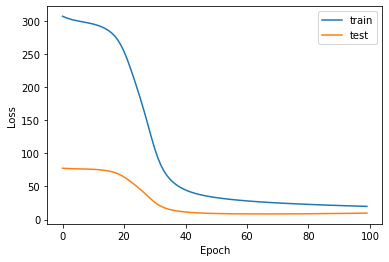

In [13]:
plt.plot(np.arange(0,iter_stop+1,1), cost_arr, label = "train")
plt.plot(np.arange(0,iter_stop+1,1), cost_arr_test, label = "test")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()